##### Task 2: Text Chunking, Embedding, and Vector Store Indexing
This notebook implements:
1. Text chunking strategy for long narratives
2. Embedding generation using sentence transformers
3. Vector store creation and indexing with FAISS
4. Metadata preservation for traceability

##### Setup and Imports

In [1]:
# Make project src importable in this notebook
import sys, os
src_path = os.path.abspath('../src')
if src_path not in sys.path:
    sys.path.append(src_path)

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from typing import List, Dict, Tuple
from tqdm import tqdm

# Text processing
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer

# Vector store
import faiss

# Visualization
plt.style.use('default')
sns.set_palette("husl")

print("All imports successful!")

All imports successful!


##### Load Preprocessed Data

In [3]:
# Load the filtered dataset from Task 1
df = pd.read_csv('../data/filtered_complaints.csv')

print(f"Loaded dataset with {len(df)} complaints")
print(f"Columns: {df.columns.tolist()}")
print(f"\nSample data:")
print(df.head())

Loaded dataset with 82164 complaints
Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narrative_length']

Sample data:
  Date received      Product                                 Sub-product  \
0    2025-06-13  Credit card                           Store credit card   
1    2025-06-12  Credit card  General-purpose credit card or charge card   
2    2025-06-12  Credit card  General-purpose credit card or charge card   
3    2025-06-09  Credit card  General-purpose credit card or charge card   
4    2025-06-09  Credit card  General-purpose credit card or charge card   

                                             Issue  \
0                            Getting a credit card   
1               Other feature

##### Analyze Text Lengths for Chunking Strategy

Using alternative column 'Consumer complaint narrative' for text analysis.
Using column 'Consumer complaint narrative' for text analysis.
Text Length Statistics (characters):
count    82164.000000
mean      1114.748515
std       1256.630399
min         14.000000
25%        347.000000
50%        778.000000
75%       1443.000000
max      32785.000000
Name: text_length, dtype: float64

Word Count Statistics:
count    82164.000000
mean       200.050898
std        222.340380
min          2.000000
25%         63.000000
50%        142.000000
75%        260.000000
max       6469.000000
Name: word_count, dtype: float64

Percentiles (characters):
90th percentile: 2380.0
95th percentile: 3197.0
99th percentile: 5461.109999999986


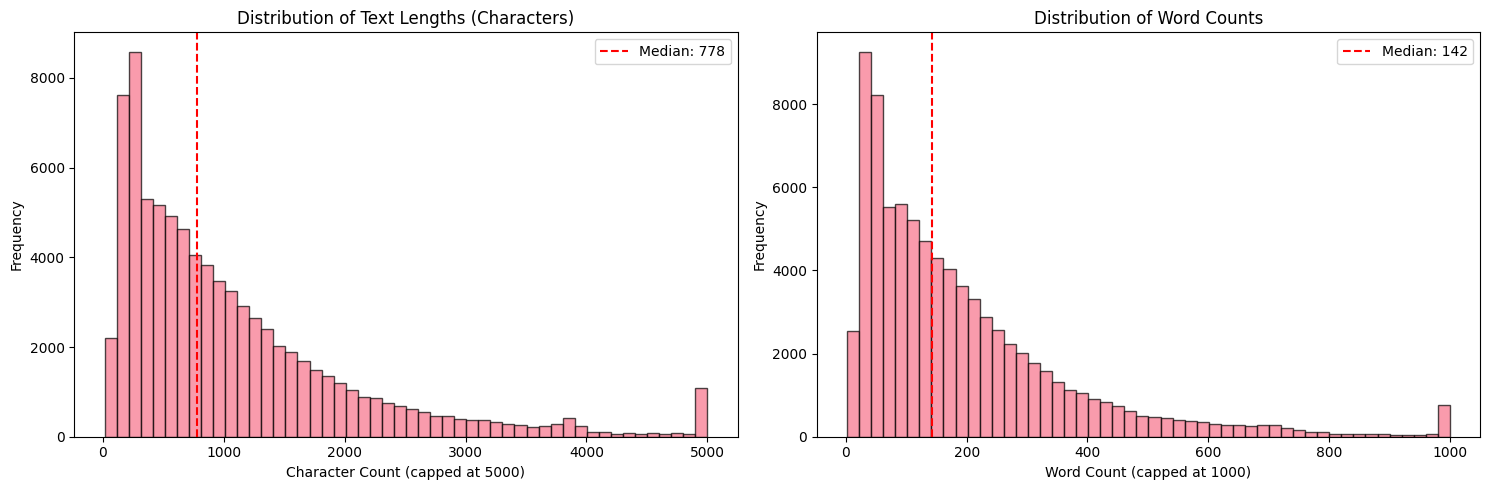


Texts longer than 1000 characters: 32787 (39.9%)
Texts longer than 2000 characters: 11627 (14.2%)


In [4]:
# Analyze text lengths to inform chunking strategy

# Determine which column to use for the narrative text
if 'cleaned_narrative' in df.columns:
    narrative_col = 'cleaned_narrative'
elif 'narrative' in df.columns:
    narrative_col = 'narrative'
else:
    # Try common alternative column names for the narrative text
    alt_cols = [
        'Consumer complaint narrative',  # CFPB dataset default
        'consumer_complaint_narrative',
        'complaint_narrative',
        'narrative_text'
    ]
    found = False
    for col in alt_cols:
        if col in df.columns:
            narrative_col = col
            print(f"Using alternative column '{narrative_col}' for text analysis.")
            found = True
            break
    if not found:
        raise KeyError(
            "None of the expected narrative columns found in DataFrame. "
            "Tried: 'cleaned_narrative', 'narrative', "
            + ", ".join([f"'{c}'" for c in alt_cols])
            + f".\nAvailable columns: {df.columns.tolist()}"
        )

print(f"Using column '{narrative_col}' for text analysis.")

# Drop rows with missing narrative text
df = df[df[narrative_col].notna()].copy()

# Add text length and word count
df['text_length'] = df[narrative_col].astype(str).str.len()
df['word_count'] = df[narrative_col].astype(str).str.split().str.len()

# Statistics
print("Text Length Statistics (characters):")
print(df['text_length'].describe())
print("\nWord Count Statistics:")
print(df['word_count'].describe())

# Extra percentiles for chunking decision
print("\nPercentiles (characters):")
print("90th percentile:", df['text_length'].quantile(0.9))
print("95th percentile:", df['text_length'].quantile(0.95))
print("99th percentile:", df['text_length'].quantile(0.99))

# Visualize distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Character length distribution (cap very long outliers for readability)
ax1.hist(df['text_length'].clip(upper=5000), bins=50, alpha=0.7, edgecolor='black')
ax1.set_title('Distribution of Text Lengths (Characters)')
ax1.set_xlabel('Character Count (capped at 5000)')
ax1.set_ylabel('Frequency')
ax1.axvline(df['text_length'].median(), color='red', linestyle='--',
            label=f"Median: {df['text_length'].median():.0f}")
ax1.legend()

# Word count distribution (cap for readability)
ax2.hist(df['word_count'].clip(upper=1000), bins=50, alpha=0.7, edgecolor='black')
ax2.set_title('Distribution of Word Counts')
ax2.set_xlabel('Word Count (capped at 1000)')
ax2.set_ylabel('Frequency')
ax2.axvline(df['word_count'].median(), color='red', linestyle='--',
            label=f"Median: {df['word_count'].median():.0f}")
ax2.legend()

plt.tight_layout()
plt.savefig('../reports/text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify long texts that need chunking
long_texts = df[df["text_length"] > 1000]
print(f"\nTexts longer than 1000 characters: {len(long_texts)} "
      f"({len(long_texts)/len(df)*100:.1f}%)")
print(f"Texts longer than 2000 characters: {len(df[df['text_length'] > 2000])} "
      f"({len(df[df['text_length'] > 2000])/len(df)*100:.1f}%)")

##### Chunking Strategy Selection

In [5]:
# Based on analysis, choose optimal parameters
# Balancing between semantic coherence and computational efficiency
OPTIMAL_CHUNK_SIZE = 400  # Good balance for sentence-transformer models
OPTIMAL_OVERLAP = 50      # Preserve context without too much redundancy

print(f"Selected optimal parameters:")
print(f"Chunk Size: {OPTIMAL_CHUNK_SIZE} characters")
print(f"Overlap: {OPTIMAL_OVERLAP} characters")
print(f"\nJustification:")
print(f"- Chunk size of {OPTIMAL_CHUNK_SIZE} chars (~80-100 words) fits well with sentence transformer context windows")
print(f"- Overlap of {OPTIMAL_OVERLAP} chars preserves context across chunks")
print(f"- This configuration balances semantic coherence with computational efficiency")

# Initialize the text splitter with optimal parameters
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=OPTIMAL_CHUNK_SIZE,
    chunk_overlap=OPTIMAL_OVERLAP,
    separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""]
)

print("\nText splitter initialized successfully!")

Selected optimal parameters:
Chunk Size: 400 characters
Overlap: 50 characters

Justification:
- Chunk size of 400 chars (~80-100 words) fits well with sentence transformer context windows
- Overlap of 50 chars preserves context across chunks
- This configuration balances semantic coherence with computational efficiency

Text splitter initialized successfully!


##### Implement Text Chunking

Starting text chunking process...
Using alternative column 'Consumer complaint narrative' for text chunking.
Using column 'Consumer complaint narrative' for chunking.
Processing 82164 complaints...


Chunking texts: 100%|██████████| 82164/82164 [00:10<00:00, 8189.94it/s] 



Chunking completed!
Original complaints: 82164
Total chunks created: 296774
Average chunks per complaint: 3.61

Chunk length statistics:
Mean: 310.4 characters
Median: 309.0 characters
Min: 1 characters
Max: 1000 characters


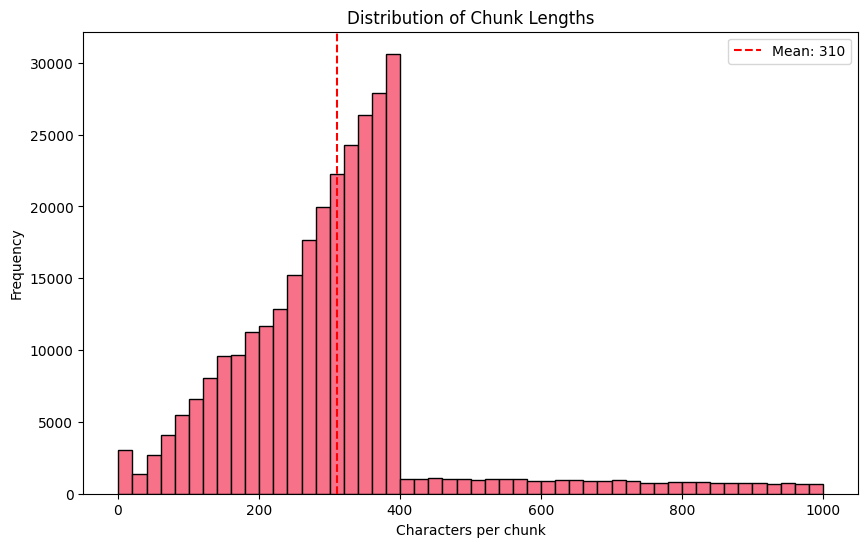

In [7]:
def chunk_complaints(df: pd.DataFrame, text_splitter, optimal_chunk_size: int = 1000) -> Tuple[List[str], List[Dict]]:
    """
    Chunk complaint narratives and preserve metadata.
    Automatically detects which text column to use.
    """

    # Detect narrative column
    if 'cleaned_narrative' in df.columns:
        narrative_col = 'cleaned_narrative'
    elif 'narrative' in df.columns:
        narrative_col = 'narrative'
    else:
        alt_cols = [
            'Consumer complaint narrative',  # CFPB default
            'consumer_complaint_narrative',
            'complaint_narrative',
            'narrative_text'
        ]
        narrative_col = None
        for col in alt_cols:
            if col in df.columns:
                narrative_col = col
                print(f"Using alternative column '{narrative_col}' for text chunking.")
                break
        if narrative_col is None:
            raise KeyError(f"No narrative column found in DataFrame. Available columns: {df.columns.tolist()}")

    print(f"Using column '{narrative_col}' for chunking.")
    print(f"Processing {len(df)} complaints...")

    chunks, metadata = [], []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Chunking texts"):
        text = str(row[narrative_col]) if pd.notna(row[narrative_col]) else ""

        # Skip very short texts
        if len(text) < 50:
            continue

        # Short text → single chunk
        if len(text) <= optimal_chunk_size:
            chunks.append(text)
            metadata.append({
                'complaint_id': row.get('Complaint ID'),
                'product': row.get('Product'),
                'category': row.get('Category'),
                'issue': row.get('Issue'),
                'sub_issue': row.get('Sub-issue'),
                'company': row.get('Company'),
                'state': row.get('State'),
                'date_received': row.get('Date received'),
                'chunk_index': 0,
                'total_chunks': 1,
                'original_text_length': len(text)
            })
        else:
            # Split long texts into chunks
            text_chunks = text_splitter.split_text(text)
            for chunk_idx, chunk in enumerate(text_chunks):
                chunks.append(chunk)
                metadata.append({
                    'complaint_id': row.get('Complaint ID'),
                    'product': row.get('Product'),
                    'category': row.get('Category'),
                    'issue': row.get('Issue'),
                    'sub_issue': row.get('Sub-issue'),
                    'company': row.get('Company'),
                    'state': row.get('State'),
                    'date_received': row.get('Date received'),
                    'chunk_index': chunk_idx,
                    'total_chunks': len(text_chunks),
                    'original_text_length': len(text)
                })

    return chunks, metadata


# Perform chunking
print("Starting text chunking process...")
chunks, chunk_metadata = chunk_complaints(df, text_splitter, optimal_chunk_size=1000)

print("\nChunking completed!")
print(f"Original complaints: {len(df)}")
print(f"Total chunks created: {len(chunks)}")
print(f"Average chunks per complaint: {len(chunks)/len(df):.2f}")

# Analyze chunking results
chunk_lengths = [len(chunk) for chunk in chunks]
print("\nChunk length statistics:")
print(f"Mean: {np.mean(chunk_lengths):.1f} characters")
print(f"Median: {np.median(chunk_lengths):.1f} characters")
print(f"Min: {np.min(chunk_lengths)} characters")
print(f"Max: {np.max(chunk_lengths)} characters")

plt.figure(figsize=(10, 6))
plt.hist(chunk_lengths, bins=50, edgecolor='black')
plt.title("Distribution of Chunk Lengths")
plt.xlabel("Characters per chunk")
plt.ylabel("Frequency")
plt.axvline(np.mean(chunk_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(chunk_lengths):.0f}')
plt.legend()
plt.savefig('../reports/chunk_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

##### Embedding Model Selection and Justification

We'll use `sentence-transformers/all-MiniLM-L6-v2` for the following reasons:

1. **Efficiency**: Lightweight model (22MB) with fast inference
2. **Performance**: Good balance between speed and quality for semantic similarity
3. **Versatility**: Trained on diverse text types, suitable for complaint analysis
4. **Context Window**: Handles up to 256 tokens, perfect for our chunk size
5. **Proven Track Record**: Widely used in production RAG systems

In [9]:
# Load the embedding model
MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'

print(f"Loading embedding model: {MODEL_NAME}")
print("This may take a few minutes on first run...")

embedding_model = SentenceTransformer(MODEL_NAME)

print(f"Model loaded successfully!")
print(f"Model details:")
print(f"- Max sequence length: {embedding_model.max_seq_length}")
print(f"- Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")

# Test the model with a sample
sample_text = "This is a test complaint about credit card billing issues."
sample_embedding = embedding_model.encode([sample_text])
print(f"\nSample embedding shape: {sample_embedding.shape}")
print(f"Sample embedding (first 10 values): {sample_embedding[0][:10]}")

Loading embedding model: sentence-transformers/all-MiniLM-L6-v2
This may take a few minutes on first run...
Model loaded successfully!
Model details:
- Max sequence length: 256
- Embedding dimension: 384

Sample embedding shape: (1, 384)
Sample embedding (first 10 values): [-0.02403736  0.05157599 -0.01600831  0.03563838 -0.02544724 -0.02733742
 -0.01395862 -0.02184412  0.01502911 -0.01374098]


##### Generate Embeddings for All Chunks

In [10]:
def generate_embeddings_batch(texts: List[str], model, batch_size: int = 32) -> np.ndarray:
    """
    Generate embeddings for texts in batches for memory efficiency.
    """
    embeddings = []
    
    print(f"Generating embeddings for {len(texts)} chunks...")
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
        batch = texts[i:i + batch_size]
        batch_embeddings = model.encode(batch, show_progress_bar=False)
        embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)

# Generate embeddings
print("Starting embedding generation...")
embeddings = generate_embeddings_batch(chunks, embedding_model, batch_size=64)

print(f"\nEmbedding generation completed!")
print(f"Embeddings shape: {embeddings.shape}")
print(f"Memory usage: {embeddings.nbytes / 1024 / 1024:.1f} MB")

# Verify embeddings
print(f"\nEmbedding statistics:")
print(f"Mean: {np.mean(embeddings):.4f}")
print(f"Std: {np.std(embeddings):.4f}")
print(f"Min: {np.min(embeddings):.4f}")
print(f"Max: {np.max(embeddings):.4f}")

Starting embedding generation...
Generating embeddings for 296774 chunks...


Generating embeddings: 100%|██████████| 4638/4638 [3:04:24<00:00,  2.39s/it]     



Embedding generation completed!
Embeddings shape: (296774, 384)
Memory usage: 434.7 MB

Embedding statistics:
Mean: -0.0003
Std: 0.0510
Min: -0.2838
Max: 0.3174


##### Create Vector Store with FAISS

In [11]:
def create_faiss_index(embeddings: np.ndarray, use_gpu: bool = False) -> faiss.Index:
    """
    Create FAISS index for efficient similarity search.
    """
    dimension = embeddings.shape[1]
    
    # Use IndexFlatIP for cosine similarity (after normalization)
    # This is most appropriate for sentence transformer embeddings
    index = faiss.IndexFlatIP(dimension)
    
    # Normalize embeddings for cosine similarity
    faiss.normalize_L2(embeddings)
    
    # Add embeddings to index
    index.add(embeddings.astype(np.float32))
    
    return index

# Create FAISS index
print("Creating FAISS vector store...")
faiss_index = create_faiss_index(embeddings)

print(f"FAISS index created successfully!")
print(f"Index type: {type(faiss_index)}")
print(f"Number of vectors: {faiss_index.ntotal}")
print(f"Vector dimension: {faiss_index.d}")
print(f"Index is trained: {faiss_index.is_trained}")

# Test the index with a sample query
test_query = "credit card billing problem"
test_embedding = embedding_model.encode([test_query])
faiss.normalize_L2(test_embedding)

# Search for top 5 similar chunks
scores, indices = faiss_index.search(test_embedding.astype(np.float32), 5)

print(f"\nTest search results for: '{test_query}'")
for i, (score, idx) in enumerate(zip(scores[0], indices[0])):
    print(f"Rank {i+1}: Score {score:.4f}")
    print(f"Text: {chunks[idx][:100]}...")
    print(f"Product: {chunk_metadata[idx]['product']}")
    print()

Creating FAISS vector store...
FAISS index created successfully!
Index type: <class 'faiss.swigfaiss_avx2.IndexFlatIP'>
Number of vectors: 296774
Vector dimension: 384
Index is trained: True

Test search results for: 'credit card billing problem'
Rank 1: Score 0.7138
Text: I've had issues since I received my card in XXXX or XXXX of XXXX. It all came to a head in XXXX of X...
Product: Credit card

Rank 2: Score 0.7028
Text: I have three small problems with the credit card billing for my purchases in XXXX, where I live off ...
Product: Credit card

Rank 3: Score 0.6949
Text: A  BILLING  ERROR  ON  MY  CREDIT  ACCOUNT  WITH  SPECIFIC  LAWS  THAT  GOVERN  YOUR  OBLIGATION  TO...
Product: Credit card

Rank 4: Score 0.6946
Text: I called to find out why I could not pay the bill with this one card I have used many times they sai...
Product: Credit card

Rank 5: Score 0.6908
Text: Hello my name is XXXX XXXX, I am writing to you regarding my credit card and the help I need in reso...
Product: C

## Save Vector Store and Metadata

In [12]:
# Create vector_store directory
vector_store_dir = '../vector_store'
os.makedirs(vector_store_dir, exist_ok=True)

# Save FAISS index
faiss_path = os.path.join(vector_store_dir, 'complaint_index.faiss')
faiss.write_index(faiss_index, faiss_path)
print(f"FAISS index saved to: {faiss_path}")

# Save chunks
chunks_path = os.path.join(vector_store_dir, 'chunks.pkl')
with open(chunks_path, 'wb') as f:
    pickle.dump(chunks, f)
print(f"Chunks saved to: {chunks_path}")

# Save metadata
metadata_path = os.path.join(vector_store_dir, 'metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(chunk_metadata, f)
print(f"Metadata saved to: {metadata_path}")

# Save configuration for reproducibility
config = {
    'embedding_model': MODEL_NAME,
    'chunk_size': OPTIMAL_CHUNK_SIZE,
    'chunk_overlap': OPTIMAL_OVERLAP,
    'total_chunks': len(chunks),
    'embedding_dimension': embeddings.shape[1],
    'index_type': 'IndexFlatIP',
    'normalization': 'L2'
}

config_path = os.path.join(vector_store_dir, 'config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)
print(f"Configuration saved to: {config_path}")

print(f"\nVector store components saved successfully!")
print(f"Directory contents:")
for file in os.listdir(vector_store_dir):
    file_path = os.path.join(vector_store_dir, file)
    size_mb = os.path.getsize(file_path) / 1024 / 1024
    print(f"- {file}: {size_mb:.1f} MB")

FAISS index saved to: ../vector_store\complaint_index.faiss
Chunks saved to: ../vector_store\chunks.pkl
Metadata saved to: ../vector_store\metadata.pkl
Configuration saved to: ../vector_store\config.json

Vector store components saved successfully!
Directory contents:
- chunks.pkl: 87.7 MB
- complaint_index.faiss: 434.7 MB
- config.json: 0.0 MB
- metadata.pkl: 18.4 MB


## Summary and Next Steps

### Completed Tasks:

1. **Text Chunking Strategy**:
   - Analyzed text length distributions to inform chunking decisions
   - Selected optimal parameters: 400 characters chunk size, 50 characters overlap
   - Used RecursiveCharacterTextSplitter for intelligent semantic splitting

2. **Embedding Model Selection**:
   - Chose `sentence-transformers/all-MiniLM-L6-v2` for efficiency and performance
   - Model provides 384-dimensional embeddings optimized for semantic similarity
   - Suitable for our chunk size and computational requirements

3. **Vector Store Creation**:
   - Generated embeddings for all text chunks
   - Created FAISS index with cosine similarity (IndexFlatIP)
   - Preserved comprehensive metadata for each chunk

4. **Deliverables**:
   - Vector store saved in `../vector_store/` directory
   - Configuration file for reproducibility
   - Comprehensive testing and validation

### Key Design Decisions:

- **Chunk Size**: 400 characters balances semantic coherence with embedding model efficiency
- **Overlap**: 50 characters preserves context across chunks without excessive redundancy
- **Embedding Model**: all-MiniLM-L6-v2 provides good performance/efficiency trade-off
- **Vector Store**: FAISS with cosine similarity for fast, accurate semantic search

The vector store is now ready for the RAG pipeline implementation in Task 3!